# Bonus assignment:

**BIOL365 Winter 2025** \
**Due date: March 31, 2025 (11:59 PM)** 

**Total marks: /30**

This notebook contains all questions for the BIOL365 bonus assignment. 

Answers should be typed in the indicated code and markdown blocks. You can create additional code blocks if needed. There is no need to save outputs separately, unless otherwise specified.

**IMPORTANT NOTES**:

- **Do not ask the TAs** for help on this assignment, they are not responsible for anything in the bonus module.

- **Attempt to troubleshoot any issues yourself first**. Most error messages can be solved by a quick google search. Stackoverflow is your friend. 

- If that doesn't work, **check the LEARN discussion forum**. I will be posting solutions to common issues there. 

- If you're still stuck, email Molly or go to office hours. It helps if you can provide screenshots and describe what you've already tried. 

- Marks are given for **final answers** only. No part marks awarded for code that fails to run!

- In the same vein, I am not specifically marking for adherence to good coding practices (e.g., formatting style). However, **I will be reviewing the code for originality**. Evidence of plagiarism will lead to a 0 on the assignment. Properly documenting your code with comments, among other things, can help you avoid this.


Good luck!

---

## Part 1: Filtering NCBI genome datasets

**/7 marks**

The NCBI FTP site (https://ftp.ncbi.nlm.nih.gov/) hosts download links for all of their databases, in a hierarchical organization. 

Follow the link for `genome/`, then `genbank/`. Download the `assembly_summary_genbank.txt` file (right click --> 'save as') into your working directory. \
Do the same for `genome/refseq/` to download the `assembly_summary_refseq.txt` file.  



### Task 1:

**A) Import both files as separate dataframes. (1 mark)** \
Hint: the `skiprows=` parameter can be used to ignore the header (https://pandas.pydata.org/docs/reference/api/pandas.read_table.html). \
You may get a warning about mixed data types, in which case you can follow the recommendation for specifying `low_memory=False`. 

In [2]:
### YOUR CODE HERE ###
!pip install pandas

import pandas as pd

# import both files
genbank_df = pd.read_table('assembly_summary_genbank.txt', skiprows=1, low_memory=False)
refseq_df = pd.read_table('assembly_summary_refseq.txt', skiprows=1, low_memory=False)

print(genbank_df.head())
print(refseq_df.head())


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  #assembly_accession  bioproject     biosample      wgs_master  \
0     GCA_000001215.4  PRJNA13812  SAMN02803731              na   
1    GCA_000001405.29  PRJNA31257            na              na   
2     GCA_000001515.5  PRJNA13184  SAMN02981217  AACZ00000000.4   
3     GCA_000001545.3  PRJNA20869  SAMN02981238  ABGA00000000.1   
4     GCA_000001635.9  PRJNA20689            na              na   

    refseq_category  taxid  species_taxid            organism_name  \
0  reference genome   7227           7227  Drosophila melanogaster   
1  reference genome   9606           9606             Homo sapiens   
2                na   9598           9598          Pan troglodytes   
3                na   9601           9601             Pongo abelii   
4  reference genome  10090          10090             Mus musculus   

  infraspecific_name                               isolate  ...  \
0                 na                                    na  ...   
1                 na                      

\
Take a look at both dataframes. They should both show a list of accession numbers, each representing an assembled genome in the database. The column headers are identical, and contain info about the source of the assembly, the species (taxid and species_taxid are both unique to the organism, listed under organism_name), and various stats such as the genome size and gene counts. 

There are too many columns to display, so for the sake of convenience, let's filter out some of the irrelevant ones. 

**B) Filter the dataframes to only contain the following columns: (1 mark)**

- `'#assembly_accession'`
- `'refseq_category'`
- `'organism_name'`
- `'assembly_level'`
- `'genome_rep'`
- `'group'`
- `'genome_size'`
- `'genome_size_ungapped'`
- `'gc_percent'`

In [3]:
### YOUR CODE HERE ###
# columns to keep
keep = [
    "#assembly_accession",
    "refseq_category",
    "organism_name",
    "assembly_level",
    "genome_rep",
    "group",
    "genome_size",
    "genome_size_ungapped",
    "gc_percent"
]
# select certain columns
genbank_df = genbank_df[keep]
refseq_df = refseq_df[keep]
print(genbank_df.head())
print(refseq_df.head())

  #assembly_accession   refseq_category            organism_name  \
0     GCA_000001215.4  reference genome  Drosophila melanogaster   
1    GCA_000001405.29  reference genome             Homo sapiens   
2     GCA_000001515.5                na          Pan troglodytes   
3     GCA_000001545.3                na             Pongo abelii   
4     GCA_000001635.9  reference genome             Mus musculus   

  assembly_level genome_rep                 group  genome_size  \
0     Chromosome       Full          invertebrate    143706478   
1     Chromosome       Full  vertebrate_mammalian   3099734149   
2     Chromosome       Full  vertebrate_mammalian   3231154112   
3     Chromosome       Full  vertebrate_mammalian   3437863358   
4     Chromosome       Full  vertebrate_mammalian   2728206152   

   genome_size_ungapped  gc_percent  
0             142553500        42.0  
1            2948611470        41.0  
2            3132603083        41.0  
3            3091404838        40.5  
4   

---


### Task 2: 

Recall that refseq is a curated, non-redundant version of genbank - one sequence per gene per organism. However, for the genome assembly dataset, the level of redundancy is debatable... for example, using `['organism_name'].value_counts()` on the refseq dataframe shows 37,570 genomes for E. coli. This could be due to different strains, assembly methods, etc. 

Regardless, I'm interested in filtering a list of *high quality genomes* with *one unique entry* per species , with the following criteria:

1. Only keep entries listed as `'Full'` under `['genome_rep']` (excludes partial genomes). 
2. Only keep entries listed as `'bacteria'`, `'archaea'`, `'fungi'`, `'invertebrate'`, `'plant'`, `'vertebrate_other'`, `'vertebrate_mammalian'`, and `'protozoa'` under `['group']` (excludes viral, metagenome, and other genomes). 
3. Keep only one value per species (`['organism_name']`), prioritizing entries listed as a `reference genome` under `['refseq_category']`.


**A)** **Apply the above filtering criteria to both the genbank and refseq datasets. (2 marks)**

Hint: the `df.drop_duplicates()` function is useful here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html \
Note the `subset=` parameter. 

In [4]:
# keep entries listed as full
filtered_genbank_df = genbank_df[genbank_df['genome_rep'] == 'Full']
filtered_refseq_df = refseq_df[refseq_df['genome_rep'] == 'Full']
# keep entries listed as _ under group
keep_groups = [
    'bacteria', 'archaea', 'fungi', 'invertebrate', 
    'plant', 'vertebrate_other', 'vertebrate_mammalian', 'protozoa'
]
filtered_genbank_df = filtered_genbank_df[filtered_genbank_df['group'].isin(keep_groups)]
filtered_refseq_df = filtered_refseq_df[filtered_refseq_df['group'].isin(keep_groups)]
# sort by refseq, so that reference genomes come first
filtered_genbank_df = filtered_genbank_df.sort_values(by='refseq_category', ascending=False)
filtered_refseq_df = filtered_refseq_df.sort_values(by='refseq_category', ascending=False)
# sanity check sort
print(filtered_genbank_df.head())
print(filtered_refseq_df.head())
print(filtered_genbank_df.tail())
print(filtered_refseq_df.tail())
# drop dups, keep first
filtered_genbank_df = filtered_genbank_df.drop_duplicates(subset=['organism_name'], keep="first")
filtered_refseq_df = filtered_refseq_df.drop_duplicates(subset=['organism_name'], keep="first")
print(filtered_genbank_df.head())
print(filtered_refseq_df.head())
print("SIZE: ", len(filtered_genbank_df))
print("SIZE: ", len(filtered_refseq_df))

        #assembly_accession   refseq_category            organism_name  \
0           GCA_000001215.4  reference genome  Drosophila melanogaster   
314799      GCA_006539865.1  reference genome        Zoogloea ramigera   
981045      GCA_020012125.1  reference genome  Hymenobacter psoromatis   
1118541     GCA_022758105.1  reference genome      Pangasianodon gigas   
1118543     GCA_022758145.1  reference genome     Pontibacter vulgaris   

        assembly_level genome_rep             group  genome_size  \
0           Chromosome       Full      invertebrate    143706478   
314799          Contig       Full          bacteria      4605859   
981045          Contig       Full          bacteria      5146772   
1118541     Chromosome       Full  vertebrate_other    827231152   
1118543         Contig       Full          bacteria      4191305   

         genome_size_ungapped  gc_percent  
0                   142553500        42.0  
314799                4605859        67.0  
981045        

**B) How many genomes are in the filtered datasets? (1 mark)**

RefSeq: 142887

GenBank: 88082


\
Next, I want to combine the datasets by adding any genbank genomes that do *not* have an equivalent refseq entry to the refseq dataframe. The accession numbers are similar between refseq and genbank - the only difference being that refseq uses GCF and genbank uses GCA. The 9-digit numerical values in both accessions (excluding the ones after the period, which refer to version number) are shared between entries. 

For example, GCF_000001405.40 and GCA_000001405.29 both map to the same reference genome (*Homo sapiens* assembly GRCh38.p14: https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.40/). 


\
**C) Create a single dataframe from the refseq and genbank data that contains one unique entry per genome (i.e., remove duplicate GCF/GCA entries). Prioritize refseq entries over genbank entries. Display the dataframe. (2 marks)** 

Hint: The `pd.concat([df1,df2])` function concatenates dataframes by rows: https://pandas.pydata.org/docs/reference/api/pandas.concat.html. 

In [5]:
### YOUR CODE HERE ###
# create new column to drop based on ids extracted with regex
filtered_genbank_df['id'] = filtered_genbank_df['#assembly_accession'].str.extract(r'GCA_(\d{9})')
filtered_refseq_df['id'] = filtered_refseq_df['#assembly_accession'].str.extract(r'GCF_(\d{9})')

# concat refseq with genbank, so refseq comes first
combined_df = pd.concat([filtered_refseq_df, filtered_genbank_df])

# drop based on id column, keep first
final_df = combined_df.drop_duplicates(subset=['id'], keep="first").drop(columns='id')

# display result
final_df

,#assembly_accession,refseq_category,organism_name,assembly_level,genome_rep,group,genome_size,genome_size_ungapped,gc_percent
0,GCF_000001215.4,reference genome,Drosophila melanogaster,Chromosome,Full,invertebrate,143706478,142553500,42.0
23016,GCF_000708205.1,reference genome,Mixia osmundae IAM 14324,Scaffold,Full,fungi,13634488,13556769,55.5
82890,GCF_002286965.1,reference genome,Halovibrio salipaludis,Contig,Full,bacteria,3495096,3495096,62.0
82888,GCF_002286935.1,reference genome,Bifidobacterium criceti,Contig,Full,bacteria,2155882,2155882,62.5
82887,GCF_002286915.1,reference genome,Bifidobacterium italicum,Contig,Full,bacteria,2276351,2276351,65.5
...,...,...,...,...,...,...,...,...,...
939280,GCA_019173565.1,na,Salmonella enterica subsp. salamae serovar II ...,Contig,Full,bacteria,5388803,5388803,51.5
938762,GCA_019163155.1,na,Pelodictyon phaeoclathratiforme,Scaffold,Full,bacteria,2666038,2665156,48.0
938908,GCA_019166125.1,na,Alcaligenaceae bacterium CGII-47,Contig,Full,bacteria,3447753,3447753,56.5
939421,GCA_019176365.1,na,Aspergillus sp. GbtcF1,Contig,Full,fungi,28831586,28831586,49.5


---

## Part 2: Genome statistics 

**/16 marks**

Let's investigate some relationships between qualitative and quantitative variables in our filtered dataframe. \
Note: plot formatting is not required unless explicitly stated.

### Task 3:

The filtered genomes should all belong to domains archaea, bacteria, and eukarya. Currently, eukaryotes are not explicitly listed in the `['group']` column. 


**A) Create box plots comparing the % GC content of bacterial, archaeal, and eukaryotic genomes (3 categories total). (3 marks)**


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\zhang\AppData\Local\Temp\ipykernel_13220\2075417009.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


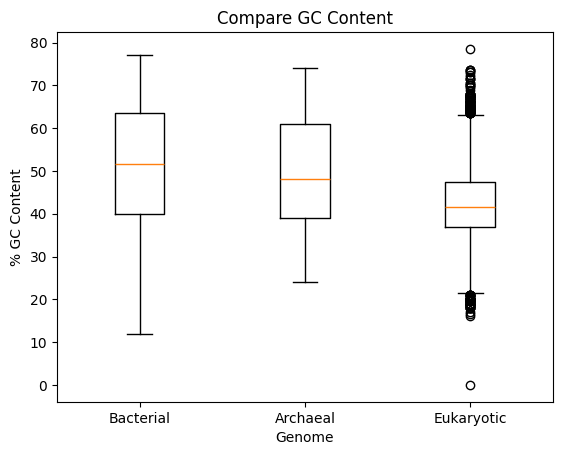

In [6]:
### YOUR CODE HERE ###
!pip install matplotlib
import matplotlib.pyplot as plt

# data to graph
bacteria_gc = final_df[final_df["group"] == "bacteria"]["gc_percent"]
archaea_gc = final_df[final_df["group"] == "archaea"]["gc_percent"]
# everything not bacteria or archaea is eukarya
eukaryote_gc = final_df[(final_df["group"] != "bacteria") & (final_df["group"] != "archaea")]["gc_percent"]
data = [
    bacteria_gc,
    archaea_gc,
    eukaryote_gc,
]

# Labels for the x-axis
labels = ["Bacterial", "Archaeal", "Eukaryotic"]

# Create the box plot
plt.figure()
plt.boxplot(data, labels=labels)

# Label the plot
plt.xlabel("Genome")
plt.ylabel("% GC Content")
plt.title("Compare GC Content")

# Show the plot
plt.show()

**B) Which group has the highest average GC content? (1 mark)**

Bacterial

**C) Perform a one-way ANOVA to test for significant differences in GC content across domains. (1 mark)** 

In [7]:
### YOUR CODE HERE ###
!pip install scipy
from scipy.stats import f_oneway

# Perform one-way ANOVA
f_stat, p_value = f_oneway(bacteria_gc, archaea_gc, eukaryote_gc)


print(f"ANOVA: {f_stat:.4f}, p-value = {p_value:.10e}")


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ANOVA: 5443.0807, p-value = 0.0000000000e+00


**E) Are the differences significant? (1 mark)**

Since p-value is less than 0.05 there is a significant difference.

---

### Task 4

**A) Create a scatter plot with the** `['genome_size']` **and** `['genome_size_ungapped']` **columns as the x and y values, respectively. Include a line of best fit. (3 marks)**


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


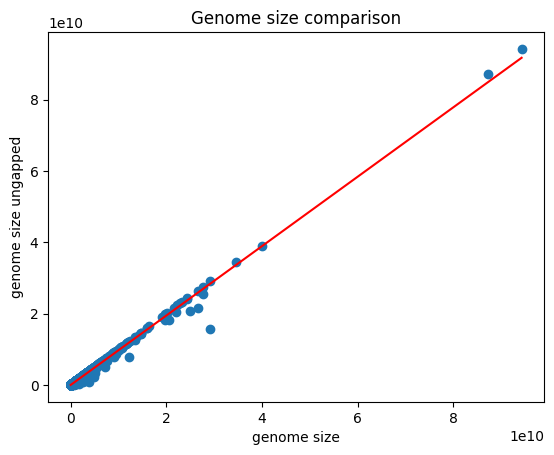

r: 0.9966360379190347


In [8]:
### YOUR CODE HERE ###
!pip install numpy

import matplotlib.pyplot as plt
import numpy as np

# data
x = final_df["genome_size"]
y = final_df["genome_size_ungapped"]

# graph
plt.figure()
plt.scatter(x, y)
# plot line of best fit 
# https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="r")
plt.xlabel("genome size")
plt.ylabel("genome size ungapped")
plt.title("Genome size comparison")

# Show the plot
plt.show()

# calculate the correlation coefficient r
# https://realpython.com/numpy-scipy-pandas-correlation-python/#example-numpy-correlation-calculation
test_r = x.corr(y)
print(f"r: {test_r}")

**B) What is the correlation coefficient (r) between genome size and ungapped genome size? (round to 3 decimals) (1 mark)**

0.997

---

### Task 5

I want to compare the distribution of assembly levels (complete genome, chromosome, contig, etc) between types of genomes in the dataset. 

**A) Create a new dataframe that groups genomes by** `['group']` **, then by** `['assembly_level']` **, showing the genome counts. Then, pivot the dataframe to show the two categories as row and column headers respectively. Scale the values in each row as a percentage of the total row values. Display the dataframe. (3 marks)**

In [9]:
### YOUR CODE HERE ###
# group, count and add index
assembly_counts = final_df.groupby(["group", "assembly_level"]).size().reset_index(name="count")
print(assembly_counts.head())

# pivot so index is group, column is assembly level
pivot_df = assembly_counts.pivot(index="group", columns="assembly_level", values="count")

# calculate percentages for each row
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Display the dataframe
print(pivot_df.head())

      group   assembly_level  count
0   archaea       Chromosome     22
1   archaea  Complete Genome    584
2   archaea           Contig   1472
3   archaea         Scaffold   1461
4  bacteria       Chromosome   1876
assembly_level  Chromosome  Complete Genome     Contig   Scaffold
group                                                            
archaea           0.621645        16.501837  41.593671  41.282848
bacteria          1.546642        12.544623  45.881529  40.027206
fungi             4.616420         2.987887  28.654105  63.741588
invertebrate     42.989396         0.403972  23.211581  33.395051
plant            47.336607         1.737816  15.035890  35.889686


**B) Create a stacked bar plot using the above dataframe (3 marks). The plot must have the following:**
- A title
- X and Y axis labels
- The legend outside of the plot area, with the labels matching the order of how they are displayed on the bars

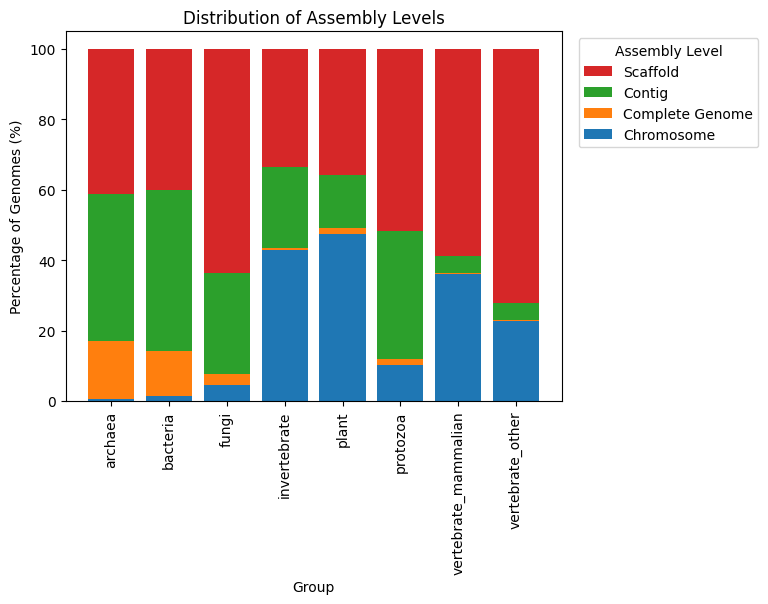

In [10]:
### YOUR CODE HERE ###
fig, ax = plt.subplots()

# labels
assembly_levels = pivot_df.columns.tolist()

# generate stacked bar plot
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html
bottom = np.zeros(len(pivot_df))

for i, level in enumerate(assembly_levels):
    ax.bar(
        pivot_df.index, pivot_df[level], label=level, bottom=bottom
    )
    bottom += pivot_df[level]

ax.set_xlabel("Group")
ax.set_ylabel("Percentage of Genomes (%)")
ax.set_title("Distribution of Assembly Levels")

# fix labels
plt.xticks(rotation=90, ha="center")

# legend, moved out and flipped
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Assembly Level", bbox_to_anchor=(1.02, 1), loc="upper left")

# Show the plot
plt.show()

---

## Part 3: Labelling phylogenomic trees 

**/7 marks**

Python does have several libraries for parsing FASTA files, aligning sequences, creating/visualizing trees, etc. One major one is Biopython (https://biopython.org/docs/latest/index.html). However, for this assignment I have made the tree using other command line tools.

A brief explanation of the steps I used, for your interest only:

- Filtered the genome dataset to only refseq genomes under `vertebrate_mammalian` (from experience, rendering a 100k+ node tree will crash the online visualizer...)
- Exported the accession numbers as a text file (`genome_accessions.txt`)
- Ran the program `GToTree` (https://github.com/AstrobioMike/GToTree), with the following code:

```bash
GToTree -a genome_accessions.txt -H Universal -j 20 -o ToL -G 0 -B
```

GToTree is a convenient pipeline that combines several other command line bioinformatics software. It uses HMMs (`HMMER`) to find a set of shared marker genes within input genomes (which can be FASTA files uploaded by the user or NCBI accessions that it will download). Then, it aligns them (`MUSCLE`), concatenates the alignments, and finally uses `FastTree`/`IQ-Tree` to create a *phylogenomic* tree of the genomes. The command `-H Universal` in the run code specifies to use the universal 16 marker gene set (Hug et al. 2016), which is a set of ribosomal genes shared between all three domains (bacteria, archaea, eukaryotes). In theory, these could be used for any tree, though it may not be ideal for resolving evolutionary relationships for closely related clades...


---

### Task 6


The output tree file (`mammal_tree.nwk`) is provided. To visualize it, go to the online Interactive Tree of Life tool (https://itol.embl.de/upload.cgi), select the tree file under Choose File, and click Upload. 

As you can see, it automatically renders a circular tree and labels it with the accession numbers. We would like to replace the labels with something more informative, such as the species name. 

Run the following code to generate a list of tree nodes (as a dataframe):

In [11]:
#you only need to do this once, you can comment this line out after
!pip install Biopython 

from Bio import Phylo
tree = Phylo.read('mammal_tree.nwk', "newick")

#extracting nodes as a dataframe column
tree_nodes = pd.DataFrame([node.name for node in tree.get_terminals()], columns=['#assembly_accession'])
tree_nodes = tree_nodes.set_index('#assembly_accession') #setting column as index

tree_nodes #take a look at the df


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


""
#assembly_accession
GCF_023721935.1
GCF_018350215.1
GCF_024362965.1
GCF_028018385.1
GCF_007474595.2
...
GCF_027475565.1
GCF_016509475.1
GCF_003327715.1


**A) Create another column in the** `tree_nodes` **dataframe that maps the associated species name** (`['organism_name']`) **to the accession. Display the dataframe. (2 marks)** 
Hint: use `df.set_index()` to set a column as an index. The resulting dataframe should only have 1 column (not including the index).

In [12]:
### YOUR CODE HERE ###

# create a mapping using refseq genome 
mapping = refseq_df.set_index("#assembly_accession")["organism_name"]

# map to create column
tree_nodes["organism_name"] = tree_nodes.index.map(mapping)

# Display the updated dataframe
print(tree_nodes)

                                organism_name
#assembly_accession                          
GCF_023721935.1                Panthera uncia
GCF_018350215.1                  Panthera leo
GCF_024362965.1               Panthera pardus
GCF_028018385.1             Neofelis nebulosa
GCF_007474595.2               Lynx canadensis
...                                       ...
GCF_027475565.1              Acinonyx jubatus
GCF_016509475.1      Prionailurus bengalensis
GCF_003327715.1                 Puma concolor
GCF_018350195.1               Panthera tigris
GCF_028533385.1                 Panthera onca

[231 rows x 1 columns]


**B) Export the dataframe as a .csv file. Include the** `header=False` **parameter to ignore the column names.** 

In [13]:
### YOUR CODE HERE ###
tree_nodes.to_csv("tree_nodes.csv", header=False)

Open the .csv file in a text editor, and append the following 3 lines before the data:

LABELS

SEPARATOR COMMA

DATA

Save the file, and click + drag it into the iToL viewer with your tree. The labels should now be updated with species names. 

---

### Task 7

In addition to text labels, color-coding the branches of our tree can help visualize phylogenetic relationships between groups. 

The `taxonomy_key.csv` file contains detailed lineage information about each genome. It was also retrieved from the NCBI FTP site under `/pub/taxonomy/`, but I have reformatted it to make it easier to work with. 

**A) Using this file, create and display a dataframe that maps each tree node (by accession) to a color hex code based on the value in the** `['Order']` **column: (2 marks)**

Carnivora: Red (`'#ff0000'`) \
Artiodactyla: Blue (`'#0000ff'`) \
Rodentia: Green (`'#00ff00'`) \
Primates: Orange (`'#ff6600'`) \
Chiroptera: Purple (`'#800080'`) \
Monotremata: Yellow (`'#ffff00'`)\
Other branches can remain black (`'#000000'`). 

The resulting dataframe (or series) should only have 1 column (not including the index).

In [14]:
### YOUR CODE HERE ###
# load
taxonomy_df = pd.read_csv("taxonomy_key.csv")

# mapping
order_to_color = {
    "Carnivora": "#ff0000",
    "Artiodactyla": "#0000ff",
    "Rodentia": "#00ff00",
    "Primates": "#ff6600",
    "Chiroptera": "#800080",
    "Monotremata": "#ffff00"
}

# map each color, use #000000 for black instead of #ffffff
taxonomy_df["color"] = taxonomy_df["Order"].map(order_to_color).fillna("#000000")

# Keep only the accession index and color column
mapping = taxonomy_df.set_index("#assembly_accession")["color"]

# map to create column
coloured_nodes = tree_nodes
coloured_nodes["color"] = tree_nodes.index.map(mapping).fillna("#000000")
coloured_nodes = coloured_nodes.drop("organism_name", axis=1)

# Display the final dataframe
coloured_nodes

,color
#assembly_accession,
GCF_023721935.1,#ff0000
GCF_018350215.1,#ff0000
GCF_024362965.1,#ff0000
GCF_028018385.1,#ff0000
GCF_007474595.2,#ff0000
...,...
GCF_027475565.1,#ff0000
GCF_016509475.1,#ff0000
GCF_003327715.1,#ff0000


**B) Export the file the same way as in Task 6.**

In [15]:
### YOUR CODE HERE ###
coloured_nodes.to_csv("taxonomy.csv", header=False)

Open the .csv file in a text editor, and append the following 5 lines before the data:

DATASET_COLORSTRIP

SEPARATOR COMMA	

DATASET_LABEL,Order

COLOR_BRANCHES,1

DATA


Save the file, and click + drag it into the iToL viewer with your tree. The branches should now be color-coded by taxonomy.

**C) Based on what you see, are there any genomes that appear to be either taxonomically misclassified OR incorrectly placed on the tree? List their scientific names below: (1 mark)**

Misplaced orange and green
- Propithecus coquereli
- Mus caroli
- Ictidomys tridecemlineatus

Misplaced purple
- Sturnira hondurensis

Black in the middle of oranges
- Cynocephalus volans
- Galeopterus variegatus
- Tupaia chinensis

---

### Task 8

Find the Monotremes, and re-root the tree on one of them by hovering over a branch and right clicking --> Tree structure --> Re-root the tree here. On the Control panel in the top right, navigate to the Basic tab and increase the Label Font Size and Branch Line Width to something readable. Then, go to the Export tab and export the Full Image as a PDF. 

**Submit the PDF tree file (2 marks) along with the assignment notebook to the dropbox for marking.**

---

**END OF ASSIGNMENT**